In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')

In [2]:
latent_dim = 2
epochs = 100
batch_size = 64
lr = 0.001
weight_decay = 1e-5
device = torch.device('cpu')
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
# define a simple linear VAE
class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=500)
        self.enc_mu = nn.Linear(in_features=500, out_features=latent_dim)
        self.enc_logvar = nn.Linear(in_features=500, out_features=latent_dim)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=latent_dim, out_features=500)
        self.dec2 = nn.Linear(in_features=500, out_features=784)
        
    def encoder(self, x):
        # Shape Flatten image to [batch_size, input_features]
        x = x.view(-1, 784)
        # Feed x into Encoder to obtain mean and logvar
        x = F.relu(self.enc1(x))
        return self.enc_mu(x), self.enc_logvar(x)
    
    def decoder(self, z):
        return torch.sigmoid(self.dec2(torch.relu(self.dec1(z))))
    
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    def forward(self, x):
        # encoding
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
 
        # decoding
        reconstruction = self.decoder(z)
        return reconstruction, mu, log_var

In [4]:
# transform to normalize the data
transform = transforms.Compose([transforms.ToTensor()])

# Download and load the training data
trainset = datasets.MNIST('./data', download=True, train=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('./data', download=True, train=False, transform=transform)
test_loader = DataLoader(testset, batch_size=64, shuffle=False)

In [5]:
model = LinearVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.BCELoss(reduction='sum')
print(model)

LinearVAE(
  (enc1): Linear(in_features=784, out_features=500, bias=True)
  (enc_mu): Linear(in_features=500, out_features=2, bias=True)
  (enc_logvar): Linear(in_features=500, out_features=2, bias=True)
  (dec1): Linear(in_features=2, out_features=500, bias=True)
  (dec2): Linear(in_features=500, out_features=784, bias=True)
)


In [6]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [7]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(trainset)/dataloader.batch_size)):
        data, _ = data
        data = data.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

In [8]:
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(testset)/dataloader.batch_size)):
            data, _ = data
            data = data.to(device)
            data = data.view(data.size(0), -1)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(testset)/dataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data.view(batch_size, 1, 28, 28)[:8], 
                                  reconstruction.view(batch_size, 1, 28, 28)[:8]))
                save_image(both.cpu(), f"E:/outputs/LinearVAE/output{epoch}.png", nrow=num_rows)
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [9]:
train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, test_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

  0%|                                                                                          | 0/937 [00:00<?, ?it/s]

Epoch 1 of 100


938it [00:21, 43.77it/s]                                                                                               
157it [00:01, 97.23it/s]                                                                                               
  1%|▍                                                                                 | 5/937 [00:00<00:21, 42.85it/s]

Train Loss: 178.2353
Val Loss: 164.9077
Epoch 2 of 100


938it [00:25, 37.21it/s]                                                                                               
157it [00:01, 95.18it/s]                                                                                               
  0%|▎                                                                                 | 4/937 [00:00<00:28, 32.87it/s]

Train Loss: 163.2086
Val Loss: 161.0623
Epoch 3 of 100


938it [00:28, 32.35it/s]                                                                                               
157it [00:01, 90.11it/s]                                                                                               
  0%|▎                                                                                 | 3/937 [00:00<00:33, 27.85it/s]

Train Loss: 160.0659
Val Loss: 158.0637
Epoch 4 of 100


938it [00:30, 30.90it/s]                                                                                               
157it [00:02, 70.06it/s]                                                                                               
  0%|▎                                                                                 | 3/937 [00:00<00:35, 26.16it/s]

Train Loss: 157.7200
Val Loss: 156.5819
Epoch 5 of 100


938it [00:31, 29.72it/s]                                                                                               
157it [00:01, 90.73it/s]                                                                                               
  0%|▎                                                                                 | 4/937 [00:00<00:30, 31.09it/s]

Train Loss: 156.0151
Val Loss: 155.4652
Epoch 6 of 100


938it [00:29, 32.18it/s]                                                                                               
157it [00:02, 73.32it/s]                                                                                               
  0%|▎                                                                                 | 3/937 [00:00<00:41, 22.28it/s]

Train Loss: 154.7277
Val Loss: 154.6748
Epoch 7 of 100


938it [00:40, 23.25it/s]                                                                                               
157it [00:02, 60.69it/s]                                                                                               
  0%|▎                                                                                 | 3/937 [00:00<00:41, 22.45it/s]

Train Loss: 153.7749
Val Loss: 153.8362
Epoch 8 of 100


938it [00:40, 23.15it/s]                                                                                               
157it [00:02, 58.74it/s]                                                                                               
  0%|▎                                                                                 | 3/937 [00:00<00:43, 21.33it/s]

Train Loss: 152.9452
Val Loss: 153.3577
Epoch 9 of 100


938it [00:40, 22.96it/s]                                                                                               
157it [00:02, 59.27it/s]                                                                                               
  0%|▎                                                                                 | 3/937 [00:00<00:40, 23.14it/s]

Train Loss: 152.2996
Val Loss: 152.7309
Epoch 10 of 100


938it [00:40, 23.08it/s]                                                                                               
157it [00:03, 50.15it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:05, 14.22it/s]

Train Loss: 151.6993
Val Loss: 152.1265
Epoch 11 of 100


938it [00:43, 21.46it/s]                                                                                               
157it [00:02, 56.75it/s]                                                                                               
  0%|▎                                                                                 | 3/937 [00:00<00:43, 21.33it/s]

Train Loss: 151.1167
Val Loss: 151.9925
Epoch 12 of 100


938it [00:42, 22.04it/s]                                                                                               
157it [00:03, 52.26it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<00:53, 17.44it/s]

Train Loss: 150.6433
Val Loss: 151.6208
Epoch 13 of 100


938it [00:42, 21.87it/s]                                                                                               
157it [00:02, 56.48it/s]                                                                                               
  0%|▎                                                                                 | 3/937 [00:00<00:43, 21.49it/s]

Train Loss: 150.2360
Val Loss: 151.2412
Epoch 14 of 100


938it [00:43, 21.33it/s]                                                                                               
157it [00:02, 55.29it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<00:48, 19.10it/s]

Train Loss: 149.8279
Val Loss: 151.4997
Epoch 15 of 100


938it [00:44, 21.13it/s]                                                                                               
157it [00:02, 54.66it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<00:50, 18.40it/s]

Train Loss: 149.3688
Val Loss: 151.1489
Epoch 16 of 100


938it [00:44, 20.89it/s]                                                                                               
157it [00:02, 54.28it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<00:50, 18.40it/s]

Train Loss: 149.0019
Val Loss: 150.2741
Epoch 17 of 100


938it [00:46, 20.37it/s]                                                                                               
157it [00:02, 53.27it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<00:51, 18.23it/s]

Train Loss: 148.6735
Val Loss: 150.1781
Epoch 18 of 100


938it [00:46, 20.07it/s]                                                                                               
157it [00:02, 52.83it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<00:52, 17.75it/s]

Train Loss: 148.3513
Val Loss: 150.1250
Epoch 19 of 100


938it [00:47, 19.54it/s]                                                                                               
157it [00:02, 52.72it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<00:51, 18.23it/s]

Train Loss: 148.0921
Val Loss: 150.0614
Epoch 20 of 100


938it [00:51, 18.26it/s]                                                                                               
157it [00:03, 47.46it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<00:55, 16.85it/s]

Train Loss: 147.8302
Val Loss: 149.4397
Epoch 21 of 100


938it [00:48, 19.31it/s]                                                                                               
157it [00:02, 53.07it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<00:48, 19.10it/s]

Train Loss: 147.5216
Val Loss: 150.6601
Epoch 22 of 100


938it [00:48, 19.29it/s]                                                                                               
157it [00:02, 53.04it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<00:54, 17.14it/s]

Train Loss: 147.3388
Val Loss: 149.3703
Epoch 23 of 100


938it [00:48, 19.16it/s]                                                                                               
157it [00:02, 52.49it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<00:51, 18.07it/s]

Train Loss: 147.0616
Val Loss: 149.5612
Epoch 24 of 100


938it [00:50, 18.59it/s]                                                                                               
157it [00:03, 45.26it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<00:59, 15.79it/s]

Train Loss: 146.9037
Val Loss: 149.3763
Epoch 25 of 100


938it [00:51, 18.09it/s]                                                                                               
157it [00:03, 50.95it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<00:55, 16.85it/s]

Train Loss: 146.6909
Val Loss: 149.2154
Epoch 26 of 100


938it [00:52, 17.94it/s]                                                                                               
157it [00:03, 47.99it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:02, 14.97it/s]

Train Loss: 146.5148
Val Loss: 149.3034
Epoch 27 of 100


938it [00:53, 17.43it/s]                                                                                               
157it [00:03, 47.47it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<00:55, 16.99it/s]

Train Loss: 146.3442
Val Loss: 149.6508
Epoch 28 of 100


938it [00:54, 17.08it/s]                                                                                               
157it [00:03, 45.87it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<00:58, 15.92it/s]

Train Loss: 146.1590
Val Loss: 148.8286
Epoch 29 of 100


938it [00:57, 16.41it/s]                                                                                               
157it [00:03, 44.19it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:02, 14.85it/s]

Train Loss: 145.9799
Val Loss: 148.9752
Epoch 30 of 100


938it [00:58, 15.95it/s]                                                                                               
157it [00:03, 42.15it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:02, 15.08it/s]

Train Loss: 145.8101
Val Loss: 148.9185
Epoch 31 of 100


938it [00:57, 16.21it/s]                                                                                               
157it [00:03, 43.09it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<00:59, 15.67it/s]

Train Loss: 145.6525
Val Loss: 149.0987
Epoch 32 of 100


938it [00:58, 15.97it/s]                                                                                               
157it [00:03, 44.21it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:02, 15.08it/s]

Train Loss: 145.5623
Val Loss: 148.7293
Epoch 33 of 100


938it [01:00, 15.47it/s]                                                                                               
157it [00:03, 42.06it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:05, 14.32it/s]

Train Loss: 145.3824
Val Loss: 148.5985
Epoch 34 of 100


938it [01:02, 15.09it/s]                                                                                               
157it [00:03, 43.06it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:06, 14.02it/s]

Train Loss: 145.2364
Val Loss: 148.6279
Epoch 35 of 100


938it [01:03, 14.77it/s]                                                                                               
157it [00:03, 43.66it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:06, 14.12it/s]

Train Loss: 145.1247
Val Loss: 148.7564
Epoch 36 of 100


938it [01:03, 14.86it/s]                                                                                               
157it [00:03, 44.26it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:06, 14.12it/s]

Train Loss: 144.9999
Val Loss: 148.7830
Epoch 37 of 100


938it [01:02, 14.96it/s]                                                                                               
157it [00:03, 44.48it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:06, 14.02it/s]

Train Loss: 144.8698
Val Loss: 148.6122
Epoch 38 of 100


938it [01:04, 14.62it/s]                                                                                               
157it [00:03, 44.38it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:06, 14.02it/s]

Train Loss: 144.7194
Val Loss: 148.7240
Epoch 39 of 100


938it [01:06, 14.14it/s]                                                                                               
157it [00:03, 45.11it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:13, 12.69it/s]

Train Loss: 144.6251
Val Loss: 148.7031
Epoch 40 of 100


938it [01:04, 14.54it/s]                                                                                               
157it [00:03, 45.76it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:09, 13.55it/s]

Train Loss: 144.5957
Val Loss: 148.7297
Epoch 41 of 100


938it [01:06, 14.11it/s]                                                                                               
157it [00:03, 44.82it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:13, 12.69it/s]

Train Loss: 144.4375
Val Loss: 148.7665
Epoch 42 of 100


938it [01:07, 13.86it/s]                                                                                               
157it [00:03, 45.79it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:14, 12.61it/s]

Train Loss: 144.3394
Val Loss: 148.5180
Epoch 43 of 100


938it [01:10, 13.32it/s]                                                                                               
157it [00:03, 44.90it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:15, 12.46it/s]

Train Loss: 144.2547
Val Loss: 149.0083
Epoch 44 of 100


938it [01:12, 12.95it/s]                                                                                               
157it [00:03, 44.02it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:14, 12.61it/s]

Train Loss: 144.1886
Val Loss: 148.6215
Epoch 45 of 100


938it [01:14, 12.60it/s]                                                                                               
157it [00:03, 45.76it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:15, 12.46it/s]

Train Loss: 144.0527
Val Loss: 148.3759
Epoch 46 of 100


938it [01:16, 12.18it/s]                                                                                               
157it [00:03, 40.61it/s]                                                                                               
  0%|                                                                                  | 1/937 [00:00<01:37,  9.64it/s]

Train Loss: 143.9928
Val Loss: 148.4061
Epoch 47 of 100


938it [01:17, 12.03it/s]                                                                                               
157it [00:03, 45.66it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:17, 12.01it/s]

Train Loss: 143.8892
Val Loss: 148.0190
Epoch 48 of 100


938it [01:18, 11.90it/s]                                                                                               
157it [00:03, 46.49it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:20, 11.59it/s]

Train Loss: 143.7962
Val Loss: 148.2418
Epoch 49 of 100


938it [01:17, 12.11it/s]                                                                                               
157it [00:03, 44.77it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:21, 11.52it/s]

Train Loss: 143.7539
Val Loss: 148.3841
Epoch 50 of 100


938it [01:16, 12.30it/s]                                                                                               
157it [00:03, 45.29it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:22, 11.39it/s]

Train Loss: 143.6206
Val Loss: 148.2243
Epoch 51 of 100


938it [01:17, 12.12it/s]                                                                                               
157it [00:04, 39.13it/s]                                                                                               
  0%|                                                                                          | 0/937 [00:00<?, ?it/s]

Train Loss: 143.5267
Val Loss: 148.4575
Epoch 52 of 100


938it [01:18, 11.95it/s]                                                                                               
157it [00:03, 47.13it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:23, 11.14it/s]

Train Loss: 143.4245
Val Loss: 148.3385
Epoch 53 of 100


938it [01:16, 12.19it/s]                                                                                               
157it [00:03, 48.95it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:19, 11.80it/s]

Train Loss: 143.3518
Val Loss: 148.0058
Epoch 54 of 100


938it [01:16, 12.19it/s]                                                                                               
157it [00:03, 47.54it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:29, 10.44it/s]

Train Loss: 143.3586
Val Loss: 148.8730
Epoch 55 of 100


938it [01:17, 12.03it/s]                                                                                               
157it [00:03, 45.55it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:21, 11.46it/s]

Train Loss: 143.2516
Val Loss: 147.8408
Epoch 56 of 100


938it [01:18, 12.00it/s]                                                                                               
157it [00:03, 47.73it/s]                                                                                               
  0%|                                                                                          | 0/937 [00:00<?, ?it/s]

Train Loss: 143.1720
Val Loss: 148.5325
Epoch 57 of 100


938it [01:19, 11.83it/s]                                                                                               
157it [00:03, 45.80it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:25, 10.96it/s]

Train Loss: 143.0925
Val Loss: 148.1223
Epoch 58 of 100


938it [01:17, 12.17it/s]                                                                                               
157it [00:03, 46.81it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:23, 11.20it/s]

Train Loss: 143.0129
Val Loss: 148.3398
Epoch 59 of 100


938it [01:17, 12.04it/s]                                                                                               
157it [00:03, 45.34it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:18, 11.87it/s]

Train Loss: 142.9169
Val Loss: 148.1999
Epoch 60 of 100


938it [01:16, 12.26it/s]                                                                                               
157it [00:03, 46.18it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:18, 11.94it/s]

Train Loss: 142.8916
Val Loss: 148.1741
Epoch 61 of 100


938it [01:15, 12.44it/s]                                                                                               
157it [00:03, 45.13it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:18, 11.94it/s]

Train Loss: 142.8337
Val Loss: 148.0898
Epoch 62 of 100


938it [01:14, 12.61it/s]                                                                                               
157it [00:03, 45.81it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:19, 11.80it/s]

Train Loss: 142.7051
Val Loss: 148.1682
Epoch 63 of 100


938it [01:14, 12.63it/s]                                                                                               
157it [00:03, 45.54it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:21, 11.46it/s]

Train Loss: 142.7070
Val Loss: 148.6849
Epoch 64 of 100


938it [01:16, 12.33it/s]                                                                                               
157it [00:03, 41.79it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:22, 11.33it/s]

Train Loss: 142.6259
Val Loss: 148.3860
Epoch 65 of 100


938it [01:13, 12.69it/s]                                                                                               
157it [00:03, 44.72it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:22, 11.27it/s]

Train Loss: 142.5097
Val Loss: 148.3539
Epoch 66 of 100


938it [01:18, 11.91it/s]                                                                                               
157it [00:04, 37.72it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:21, 11.52it/s]

Train Loss: 142.5353
Val Loss: 148.5897
Epoch 67 of 100


938it [01:20, 11.60it/s]                                                                                               
157it [00:03, 41.50it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:23, 11.14it/s]

Train Loss: 142.4348
Val Loss: 148.2637
Epoch 68 of 100


938it [01:16, 12.21it/s]                                                                                               
157it [00:03, 45.03it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:19, 11.80it/s]

Train Loss: 142.3884
Val Loss: 147.9168
Epoch 69 of 100


938it [01:14, 12.62it/s]                                                                                               
157it [00:03, 45.09it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:27, 10.72it/s]

Train Loss: 142.2809
Val Loss: 148.0433
Epoch 70 of 100


938it [01:14, 12.62it/s]                                                                                               
157it [00:03, 46.52it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:19, 11.73it/s]

Train Loss: 142.2677
Val Loss: 148.1025
Epoch 71 of 100


938it [01:16, 12.32it/s]                                                                                               
157it [00:03, 47.27it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:18, 11.94it/s]

Train Loss: 142.2275
Val Loss: 148.0289
Epoch 72 of 100


938it [01:14, 12.51it/s]                                                                                               
157it [00:03, 45.59it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:20, 11.59it/s]

Train Loss: 142.2048
Val Loss: 148.3006
Epoch 73 of 100


938it [01:14, 12.57it/s]                                                                                               
157it [00:03, 45.08it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:18, 11.94it/s]

Train Loss: 142.1679
Val Loss: 148.8578
Epoch 74 of 100


938it [01:14, 12.57it/s]                                                                                               
157it [00:03, 45.38it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:15, 12.30it/s]

Train Loss: 142.0293
Val Loss: 148.3451
Epoch 75 of 100


938it [01:14, 12.56it/s]                                                                                               
157it [00:03, 45.87it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:19, 11.80it/s]

Train Loss: 141.9974
Val Loss: 147.8277
Epoch 76 of 100


938it [01:13, 12.73it/s]                                                                                               
157it [00:03, 46.66it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:18, 11.94it/s]

Train Loss: 141.9654
Val Loss: 147.9658
Epoch 77 of 100


938it [01:15, 12.43it/s]                                                                                               
157it [00:03, 45.09it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:19, 11.73it/s]

Train Loss: 141.9313
Val Loss: 148.1063
Epoch 78 of 100


938it [01:13, 12.68it/s]                                                                                               
157it [00:03, 46.46it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:19, 11.80it/s]

Train Loss: 141.8860
Val Loss: 148.4402
Epoch 79 of 100


938it [01:16, 12.34it/s]                                                                                               
157it [00:03, 46.02it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:17, 12.01it/s]

Train Loss: 141.8218
Val Loss: 147.9307
Epoch 80 of 100


938it [01:13, 12.70it/s]                                                                                               
157it [00:03, 45.09it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:18, 11.87it/s]

Train Loss: 141.7202
Val Loss: 147.8763
Epoch 81 of 100


938it [01:14, 12.63it/s]                                                                                               
157it [00:03, 46.18it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:19, 11.73it/s]

Train Loss: 141.6991
Val Loss: 148.2605
Epoch 82 of 100


938it [01:13, 12.70it/s]                                                                                               
157it [00:03, 45.88it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:21, 11.52it/s]

Train Loss: 141.6452
Val Loss: 147.7781
Epoch 83 of 100


938it [01:14, 12.53it/s]                                                                                               
157it [00:03, 44.72it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:19, 11.73it/s]

Train Loss: 141.6759
Val Loss: 148.6037
Epoch 84 of 100


938it [01:14, 12.67it/s]                                                                                               
157it [00:03, 44.91it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:13, 12.69it/s]

Train Loss: 141.5571
Val Loss: 147.9222
Epoch 85 of 100


938it [01:13, 12.77it/s]                                                                                               
157it [00:03, 45.31it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:18, 11.94it/s]

Train Loss: 141.5123
Val Loss: 148.2244
Epoch 86 of 100


938it [01:15, 12.43it/s]                                                                                               
157it [00:03, 45.56it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:15, 12.46it/s]

Train Loss: 141.5687
Val Loss: 148.4492
Epoch 87 of 100


938it [01:14, 12.65it/s]                                                                                               
157it [00:03, 45.76it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:16, 12.23it/s]

Train Loss: 141.4300
Val Loss: 148.2842
Epoch 88 of 100


938it [01:15, 12.34it/s]                                                                                               
157it [00:03, 44.62it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:19, 11.73it/s]

Train Loss: 141.3835
Val Loss: 148.0442
Epoch 89 of 100


938it [01:16, 12.26it/s]                                                                                               
157it [00:03, 44.94it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:22, 11.39it/s]

Train Loss: 141.3628
Val Loss: 147.8728
Epoch 90 of 100


938it [01:17, 12.18it/s]                                                                                               
157it [00:03, 44.65it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:22, 11.27it/s]

Train Loss: 141.2892
Val Loss: 147.8874
Epoch 91 of 100


938it [01:17, 12.08it/s]                                                                                               
157it [00:03, 40.07it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:22, 11.33it/s]

Train Loss: 141.2535
Val Loss: 148.1449
Epoch 92 of 100


938it [01:16, 12.19it/s]                                                                                               
157it [00:03, 44.49it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:16, 12.15it/s]

Train Loss: 141.2595
Val Loss: 148.1316
Epoch 93 of 100


938it [01:14, 12.59it/s]                                                                                               
157it [00:03, 44.46it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:16, 12.23it/s]

Train Loss: 141.1907
Val Loss: 148.4383
Epoch 94 of 100


938it [01:14, 12.57it/s]                                                                                               
157it [00:04, 39.13it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:26, 10.78it/s]

Train Loss: 141.1657
Val Loss: 148.3323
Epoch 95 of 100


938it [01:16, 12.25it/s]                                                                                               
157it [00:03, 44.41it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:23, 11.20it/s]

Train Loss: 141.1598
Val Loss: 148.1104
Epoch 96 of 100


938it [01:17, 12.17it/s]                                                                                               
157it [00:03, 45.55it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:18, 11.94it/s]

Train Loss: 141.0952
Val Loss: 147.9459
Epoch 97 of 100


938it [01:16, 12.26it/s]                                                                                               
157it [00:03, 46.04it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:17, 12.08it/s]

Train Loss: 141.0783
Val Loss: 148.0533
Epoch 98 of 100


938it [01:16, 12.22it/s]                                                                                               
157it [00:03, 44.90it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:24, 11.08it/s]

Train Loss: 141.0444
Val Loss: 147.8524
Epoch 99 of 100


938it [01:18, 11.97it/s]                                                                                               
157it [00:03, 44.99it/s]                                                                                               
  0%|▏                                                                                 | 2/937 [00:00<01:23, 11.14it/s]

Train Loss: 140.9368
Val Loss: 148.2628
Epoch 100 of 100


938it [01:19, 11.80it/s]                                                                                               
157it [00:03, 45.72it/s]                                                                                               

Train Loss: 140.9531
Val Loss: 148.2993


__Python VERSION: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
__pyTorch VERSION: 1.7.0
__CUDA VERSION


'nvcc' is not recognized as an internal or external command,
operable program or batch file.


__CUDNN VERSION: 7605
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


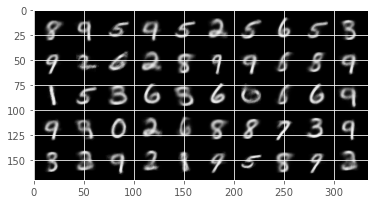

In [11]:
import numpy as np
model.eval()
with torch.no_grad():
    z = torch.randn(50, 2, device=device)
    recon_images = model.decoder(z)

    #print(recon_images.size())
    recon_images = recon_images.view(recon_images.size(0), 1, 28, 28)
    recon_images = recon_images.cpu()
    recon_images = recon_images.clamp(0, 1)
    plt.imshow(np.transpose(torchvision.utils.make_grid(recon_images, 10, 5).numpy(), (1, 2, 0)))

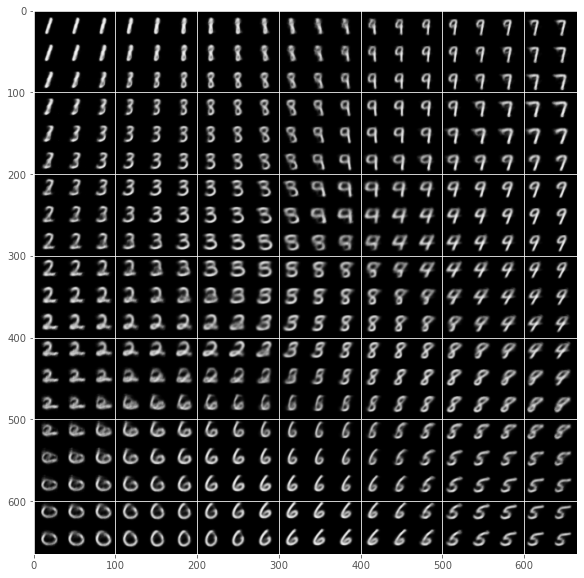

In [12]:
with torch.no_grad():
    # Create empty (x, y) grid
    latent_x = np.linspace(-1.5, 1.5, 20)
    latent_y = np.linspace(-1.5, 1.5, 20)
    latents = torch.FloatTensor(len(latent_x), len(latent_y), 2)
    # Fill up the grid
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    # Flatten the grid
    latents = latents.view(-1, 2)
    # Send to GPU
    latents = latents.to(device)
    # Find their representation
    reconstructions = model.decoder(latents).view(-1, 1, 28, 28)
    reconstructions = reconstructions.cpu()
    # Finally, plot
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.imshow(np.transpose(torchvision.utils.make_grid(reconstructions.data[:400], 20, 5).clamp(0, 1).numpy(), (1, 2, 0))) 